In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from dotenv import load_dotenv

from fastapi import FastAPI, HTTPException
import uvicorn
import nest_asyncio
import asyncio

In [2]:
nest_asyncio.apply()

In [3]:
# Create an instance of FastAPI
app = FastAPI()


In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Assignment Part 1

## Set Up RAG Pipeline

### Step 1: Load Documentation

In [6]:
loader = PyPDFLoader("iesc111.pdf")
pages = loader.load_and_split()
pages

[Document(metadata={'source': 'iesc111.pdf', 'page': 0}, page_content='Everyday we hear sounds from various\nsources like humans, bir ds, bells, machines,\nvehicles, televisions, radios etc. Sound is a\nform of ener gy which pr oduces a sensation\nof hearing in our ears. Ther e are also other\nforms of energy like mechanical energy, light\nenergy, etc. W e have talked about mechanical\nenergy in the pr evious chapters. Y ou have\nbeen taught about conservation of energy,\nwhich states that we can neither create nor\ndestr oy ener gy. W e  can just change it fr om\none for m to another . When you clap, a sound\nis produced. Can you produce sound without\nutilising your energy? Which form of energy\ndid you use to produce sound? In this\nchapter we are going to learn how sound is\nproduced and how it is transmitted through\na medium and received by our ears.\n11.1 Production of Sound\nActivity _____________ 11.1\n•Take a tuning fork and set it vibrating\nby striking its pr ong on a rubbe

### Step 2: Split Documentation

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)
splits = text_splitter.split_documents(pages)
splits

[Document(metadata={'source': 'iesc111.pdf', 'page': 0}, page_content='Everyday we hear sounds from various\nsources like humans, bir ds, bells, machines,\nvehicles, televisions, radios etc. Sound is a\nform of ener gy which pr oduces a sensation'),
 Document(metadata={'source': 'iesc111.pdf', 'page': 0}, page_content='of hearing in our ears. Ther e are also other\nforms of energy like mechanical energy, light\nenergy, etc. W e have talked about mechanical\nenergy in the pr evious chapters. Y ou have'),
 Document(metadata={'source': 'iesc111.pdf', 'page': 0}, page_content='been taught about conservation of energy,\nwhich states that we can neither create nor\ndestr oy ener gy. W e  can just change it fr om\none for m to another . When you clap, a sound'),
 Document(metadata={'source': 'iesc111.pdf', 'page': 0}, page_content='is produced. Can you produce sound without\nutilising your energy? Which form of energy\ndid you use to produce sound? In this\nchapter we are going to learn how s

### Step 3: Create a Vectorstore to Index contents of the document

In [8]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(model='text-embedding-3-small'))
vectorstore

### Step 4: Setup Retriever

In [9]:
retriever = vectorstore.as_retriever()
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x1348bc590>, search_kwargs={})

### Step 5: Setup RAG Prompt Template

In [10]:
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."),
    ("user", "context: {context}\n\nquestion: {question}")    
])

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Step 6: Create RAG Chain

In [11]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [12]:
rag_chain.invoke("What kind of wave is Sound Wave?")

'Sound waves are classified as longitudinal waves. They are characterized by the motion of particles in the medium, which move back and forth about their position of rest.'

# Assignment Part 2

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain.tools import tool
from langchain_community.tools import TavilySearchResults
from pydantic import BaseModel, Field

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

### Step 1: Create Tools

In [14]:
# Create Rag Chain as a Tool

class RagTool(BaseModel):
    user_query: str = Field(description="The user's input query to use for RAG")


@tool("rag_tool", args_schema=RagTool, return_direct=True)
def rag_tool(user_query: str) -> str:
    ''' Invokes the RAG chain To Provide an Answer to the User's Query'''
    response = rag_chain.invoke(user_query)
    return response

print(rag_tool.name)
print(rag_tool.description)
print(rag_tool.args)
print(rag_tool.return_direct)


rag_tool
Invokes the RAG chain To Provide an Answer to the User's Query
{'user_query': {'description': "The user's input query to use for RAG", 'title': 'User Query', 'type': 'string'}}
True


In [15]:
# Create a Web Search Tool

class WebSearch(BaseModel):
    user_query: str = Field(description="The user's input query to use for Web Search")
    
@tool("web_search_tool", args_schema= WebSearch, return_direct=True)
def web_search_tool(user_query: str) -> str:
    ''' Runs a web search to provide an answer based on the user's query '''
    search = TavilySearchResults(
        max_results = 5,
        search_depth = "advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=True
    )
    
    results = search.invoke({"query":user_query})
    
    return {"messages": results}

print(web_search_tool.name)
print(web_search_tool.description)
print(web_search_tool.args)
print(web_search_tool.return_direct)

web_search_tool
Runs a web search to provide an answer based on the user's query
{'user_query': {'description': "The user's input query to use for Web Search", 'title': 'User Query', 'type': 'string'}}
True


In [16]:
tools = [rag_tool, web_search_tool]
llm_with_tools = llm.bind_tools(tools)

### Step 2: Create a Robust System Message for the Agent

In [17]:
# Create a System Message

sys_msg = SystemMessage(content=
    """You are an AI assistant capable of answering questions using two tools provided to you:
    
        1. **Retrieval-Augmented Generation (RAG) Pipeline Tool**:
        - You have access to a pre-configured RAG pipeline, which is capable of retrieving relevant information about a document containing information on the topic of 'Sound'.
        - If the user's input is related to the topic of 'Sound', trigger the RAG tool.

        2. **Tavily Web Search Tool**:
        - You can use the Tavily web search tool to fetch real-time information from the web for any queries not covered by the RAG pipeline, such as current events, general knowledge, or even topics unrelated to 'Sound'.

    Deciding when to invoke a tool:
    - Use the **RAG Pipeline Tool** if the user's input is related to 'Sound'.
    - Use the **Tavily Web Search Tool** if the user's query is about 'Sound' that the document in RAG pipeline does not cover or requires real-time or broader web-based information.
    
    Do not hallucinate your answer. Use the tools provided to provide the best answer possible to the user's query.

    User Question: "{user_query}"""
)


### Step 3: Create an Assistant Node

In [18]:
# Create Assistant Node

def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"]) # The input our system message plus a dictionary `{"messages": state["messages"]}`, which sets the initial value for our state dict.
    return {"messages": response}
    

### Step 4: Build Graph

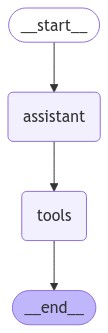

In [19]:
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", END)


graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
response = graph.invoke({"messages": HumanMessage(content="Hi")}, {"configurable": {"thread_id": "1"}})

In [21]:
for message in response['messages']:
    print(message.content)

Hi
Hello! How can I assist you today?


In [22]:
response = graph.invoke({"messages": HumanMessage(content="How does the sound produced by a vibrating object in a medium reach your ear")}, {"configurable": {"thread_id": "1"}})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

How does the sound produced by a vibrating object in a medium reach your ear
================================== Ai Message ==================================
Tool Calls:
  rag_tool (call_Z3kZh81UzZaecRpqlEeQIBlW)
 Call ID: call_Z3kZh81UzZaecRpqlEeQIBlW
  Args:
    user_query: How does the sound produced by a vibrating object in a medium reach your ear?
================================= Tool Message =================================
Name: rag_tool

The sound produced by a vibrating object in a medium reaches your ear through the vibration of particles in that medium. When the object vibrates, it displaces nearby particles, creating density and pressure variations that travel through the medium. These variati

### Step 5: Create FASTAPI Endpoint

In [23]:
# FASTAPI POST endpoint to handle user queries

class QueryRequest(BaseModel):
    user_query: str


In [24]:
@app.post("/query")
async def handle_query(query: QueryRequest):
    try:
        user_input = HumanMessage(content=query.user_query)
        response = graph.invoke({"messages": user_input}, {"configurable": {"thread_id": "1"}})
        response_messages = [message.content for message in response["messages"]]
        return response_messages

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
    
        

In [25]:
# Function to run the FastAPI server
async def run_fastapi():
    config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    await server.serve()

In [28]:
# Run the FastAPI app in Jupyter
config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)

loop = asyncio.get_event_loop()
loop.create_task(server.serve())

<Task pending name='Task-1' coro=<Server.serve() running at /opt/anaconda3/envs/sarvam_env/lib/python3.11/site-packages/uvicorn/server.py:67>>

INFO:     Started server process [41514]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:49430 - "POST /query HTTP/1.1" 200 OK


In [27]:
# Run this in the terminal 
# curl -X POST "http://localhost:8000/query" -H "Content-Type: application/json" -d '{"user_query": "What is sound?"}'
